<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
URL = "https://www.indeed.com/jobs?q=data+scientist+$20,000&l=New+York&start=0"


In [9]:
import requests
r = requests.get(URL)

In [8]:
r.text[:1000]

'<!DOCTYPE html>\n<html lang="en" dir="ltr">\n<head>\n<meta http-equiv="content-type" content="text/html;charset=UTF-8">\n<script type="text/javascript" src="/s/35f01ca/en_US.js"></script>\n<link href="/s/97464e7/jobsearch_all.css" rel="stylesheet" type="text/css">\n<link rel="alternate" type="application/rss+xml" title="Data Scientist $20,000 Jobs, Employment in New York State" href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&l=New+York">\n<link rel="alternate" media="only screen and (max-width: 640px)" href="/m/jobs?q=data+scientist+%2420%2C000&l=New+York">\n<link rel="alternate" media="handheld" href="/m/jobs?q=data+scientist+%2420%2C000&l=New+York">\n\n<script type="text/javascript">\n    \n    if (typeof window[\'closureReadyCallbacks\'] == \'undefined\') {\n        window[\'closureReadyCallbacks\'] = [];\n    }\n\n    function call_when_jsall_loaded(cb) {\n        if (window[\'closureReady\']) {\n            cb();\n        } else {\n            window[\'closureReadyCa

In [9]:
soup = BeautifulSoup(r.text, 'html.parser')

In [390]:
from pprint import pprint

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [11]:
def extract_location_from_result(soup):
    location = []
    for job in soup.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            location.append(job.find('span', attrs={'class':'location'}).text)
        except:
            try:
                location.append(job.find('div', attrs={'class':'location'}).text)
            except:
                location.append(np.nan)
    return location

In [12]:
def extract_company_from_result(soup):
    company = []
    for job in soup.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            company.append(job.find('span', attrs={'class':'company'}).text.strip())
        except:
            company.append(np.nan)
    return company

In [13]:
def extract_job_from_result(soup):
    jobs = []
    for job in soup.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            jobs.append(job.find('a', attrs={'data-tn-element':'jobTitle'}).text.strip())
        except:
            jobs.append(np.nan)
    return jobs

In [14]:
def extract_salary_from_result(soup):
    salary = []
    for job in soup.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            salary.append(job.find('span', attrs={'class':'salary no-wrap'}).text.strip())
        except:
            salary.append(np.nan)
    return salary

The following functions extract extra data from Indeed:

In [15]:
def extract_kind_from_result(soup):
    kind = []
    for job in soup.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            kind_ind = job.find_all('span', attrs={'class':'mat'})
            kind.append(kind_ind[1].text.strip())
        except:
            kind.append(np.nan)
    return kind

In [16]:
def extract_summary_from_result(soup):
    summary = []
    for job in soup.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
        try:
            summary.append(job.find('div', attrs={'class':'summary'}).text.strip())
        except:
            try:
                summary.append(job.find('span', attrs={'class':'summary'}).text.strip())
            except:
                summary.append(np.nan)
    return summary

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Colecting data from multiple cities

**IMPORTANT: I will be working with UK cities only**

In [17]:
# Cities created from here:
# https://docs.google.com/spreadsheets/d/1ZRfsM0e7noKpS2Htkfl-0lXe34xgitmP6zwWoZXvlfg/edit?usp=sharing
# Using list of cities in UK from Indeed: https://www.indeed.co.uk/m/browse?cat=loc

cities_df = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/cities-clean.csv')

In [18]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
City          125 non-null object
Population    125 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [ ]:
max_results_per_big_city = 1000
max_results_per_small_city = 50
max_results_minor_types = 30 #30 max in London for minor job types as Apprenticeship
big_cities = int(cities_df.quantile(0.90))

results = {'Location':[],
          'Company':[],
          'Job':[],
          'Salary':[],
           'Summary':[],
           'Kind':[],
          'City':[],
          "Job_Type":[],
          "Page": []} # Added to check post scrapping if some page is colecting null values due to code change

cities = cities_df.head(50)

job_type = ["commission","contract","temporary","internship","parttime","fulltime","apprenticeship"]
    
for city in cities.City:
    
    if int(cities.Population[cities.City == city]) > big_cities:
        max_results_per_city = max_results_per_big_city
    else:
        max_results_per_city = max_results_per_small_city
        
    for jtype in job_type:
        
        if jtype in list(["temporary","internship","part-time","apprenticeship"]):
            max_results_per_city = max_results_minor_types
        
        for start in tqdm_notebook(range(0, max_results_per_city, 10)):
            url = "https://www.indeed.co.uk/jobs?q=data+scientist+%2420%2C000&l={}&jt={}&start={}".format(
                city,jtype,start)
            r = requests.get(url)
            soup = BeautifulSoup(r.text,'html.parser')
            results['Location'] += extract_location_from_result(soup)
            results['Company'] += extract_company_from_result(soup)
            results['Job'] += extract_job_from_result(soup)
            results['Salary'] += extract_salary_from_result(soup)
            results['Summary'] += extract_summary_from_result(soup)
            results['Kind'] += extract_kind_from_result(soup)
            results["City"] += [city] * len(extract_job_from_result(soup))
            results["Job_Type"] += [jtype] * len(extract_job_from_result(soup))
            results["Page"] += [start/10] * len(extract_job_from_result(soup))

            pass

In [21]:
#Checking amount of results per key:

for blabla in list(results.keys()):
    print(len(results[blabla]))

14093
14093
14093
14093
14093
14093
14093
14093
14093


#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [42]:
results_df = pd.DataFrame(results,columns=results.keys())

In [43]:
results_df.shape

(14093, 9)

In [44]:
# Checking exctracted information:

results_df.head()

,Location,Company,Job,Salary,Summary,Kind,City,Job_Type,Page
0,London,Center for Combating Extremist Ideology,Lead Data Scientist - Relocation to Saudi Arab...,NaN,Copyright and data protection). We are looking...,NaN,London,contract,0.0
1,United Kingdom,Center for Combating Extremist Ideology,Data Scientist - Relocation to Saudi Arabia - ...,"£50,000 - £60,000 a year",Assist in conducting research and development ...,NaN,London,contract,0.0
2,London,Bank Partners,Senior Pharmacy Assistant Band 3,NaN,Some of the duties will include preparing samp...,NaN,London,contract,0.0
3,London,Nesta,Junior Data Scientist,"£30,000 a year",The Innovation Mapping team makes use of new d...,Salary Search: Junior Data Scientist salaries ...,London,contract,0.0
4,London,Pivigo Ltd,Data Scientist,£350 - £650 a day,Also with opportunities for Data Scientists to...,Salary Search: Data Scientist salaries in London,London,contract,0.0


Saving scrapped data for later:

In [45]:
results_df.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/results_df.csv',
                 index=False)

In [4]:
results_df = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/results_df.csv')

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

In [5]:
# Checking loading:

results_df.head()

,Location,Company,Job,Salary,Summary,Kind,City,Job_Type,Page
0,London,Center for Combating Extremist Ideology,Lead Data Scientist - Relocation to Saudi Arab...,NaN,Copyright and data protection). We are looking...,NaN,London,contract,0.0
1,United Kingdom,Center for Combating Extremist Ideology,Data Scientist - Relocation to Saudi Arabia - ...,"£50,000 - £60,000 a year",Assist in conducting research and development ...,NaN,London,contract,0.0
2,London,Bank Partners,Senior Pharmacy Assistant Band 3,NaN,Some of the duties will include preparing samp...,NaN,London,contract,0.0
3,London,Nesta,Junior Data Scientist,"£30,000 a year",The Innovation Mapping team makes use of new d...,Salary Search: Junior Data Scientist salaries ...,London,contract,0.0
4,London,Pivigo Ltd,Data Scientist,£350 - £650 a day,Also with opportunities for Data Scientists to...,Salary Search: Data Scientist salaries in London,London,contract,0.0


In [6]:
results_df.isnull().sum()

Location       0
Company        0
Job            0
Salary      6330
Summary        0
Kind        4408
City           0
Job_Type       0
Page           0
dtype: int64

In [7]:
# Droping "Page" that was a variable created to manage possible null values generated by changes in specific pages:

results_df.drop("Page",axis=1,inplace=True)

**Keeping results with salary information**

In [8]:
salary_results = results_df[results_df["Salary"].notnull()]
salary_results.reset_index(drop=True,inplace=True)
salary_results = salary_results.drop_duplicates(keep="last") 

#Keeping last while dropping duplicates since sponsored ads are incomplete and appear first

In [9]:
salary_results.shape

(1707, 8)

**Obtaining industry information from the about page of each company in Indeed**

In [10]:
companies = pd.DataFrame(salary_results.Company.unique(),columns=["Company"])

In [11]:
companies_search = companies.Company.str.replace(" - ", "---")

In [12]:
# Creating function to scrap information

def extract_industry_from_result(soup):
    industry = ""
    try:
        industry = soup.find('a', attrs={'data-tn-element':'industryLink'}).text.strip()
    except:
        industry = "Other"
    return industry

In [13]:
# Scapping indstry from Indeed company profile

industry = []

for company in companies_search:
    url_ = "https://www.indeed.co.uk/cmp/{}/about".format(company)
    r_ = requests.get(url_)
    soup_ = BeautifulSoup(r_.text,'html.parser')
    industry.append(extract_industry_from_result(soup_))

In [14]:
industry_dict = {"Company": list(companies.Company),
               "Industry": list(industry)}

In [15]:
industry_df = pd.DataFrame(industry_dict,
                           columns=["Company","Industry"])

In [16]:
salary_results_ind = pd.merge(salary_results, industry_df, on='Company', how='left')

In [17]:
salary_results_ind.shape

(1707, 9)

**Cleaning salaries information**

In [18]:
# Note: all this was done before learning regex :(

In [19]:
cleaning_salaries = salary_results_ind.Salary.str.split(expand=True,)

In [20]:
cleaning_salaries.head()

,0,1,2,3,4
0,"£30,000",a,year,None,None
1,£350,-,£650,a,day
2,£400,-,£500,a,day
3,£365,-,£450,a,week
4,£550,a,day,None,None


In [21]:
cleaning_salaries.columns = ["From","X1","To","X2","Period"]

In [22]:
cleaning_salaries.From = cleaning_salaries.From.str.replace("£","")
cleaning_salaries.To = cleaning_salaries.To.str.replace("£","")
cleaning_salaries.From = cleaning_salaries.From.str.replace(",","")
cleaning_salaries.To = cleaning_salaries.To.str.replace(",","")
cleaning_salaries.From = cleaning_salaries.From.str.replace(".","")
cleaning_salaries.To = cleaning_salaries.To.str.replace(".","")

In [23]:
period_ok = []
periods = list(cleaning_salaries.Period.value_counts().index)
periods.append("month")
for each in cleaning_salaries.index:
    flag = False
    for period in periods:
        if cleaning_salaries.X1.iloc[each] == period or cleaning_salaries.To.iloc[each] == period\
        or cleaning_salaries.X2.iloc[each] == period or cleaning_salaries.Period.iloc[each] == period:
            period_ok.append(period)
            flag = True
    if not flag:
        period_ok.append(np.nan)

In [24]:
cleaning_salaries["Period_ok"] = period_ok
cleaning_salaries.drop(["X1","X2","Period"],axis=1,inplace=True)

In [25]:
average_salary = []

# Getting average salary if needed and transforming it into anually
# The period transformation into anualy has been done assuming:
# * that we have all 8hs positions
# * that all the positions work 5 days a week

for each in cleaning_salaries.index:
    try:
        avg_salary = (int(cleaning_salaries.From.iloc[each]) + int(cleaning_salaries.To.iloc[each]))/2
    except:
        avg_salary = int(cleaning_salaries.From.iloc[each])
    if cleaning_salaries.Period_ok.iloc[each] == "year":
        average_salary.append(avg_salary)
    elif cleaning_salaries.Period_ok.iloc[each] == "month":
        avg_salary = avg_salary * 12
        average_salary.append(avg_salary)
    elif cleaning_salaries.Period_ok.iloc[each] == "week":
        avg_salary = avg_salary * 52
        average_salary.append(avg_salary)
    elif cleaning_salaries.Period_ok.iloc[each] == "day":
        avg_salary = avg_salary * 5 * 52
        average_salary.append(avg_salary)
    elif cleaning_salaries.Period_ok.iloc[each] == "hour":
        avg_salary = avg_salary * 8 * 5 * 52
        average_salary.append(avg_salary)
    else:
        average_salary.append(np.nan)

In [26]:
working_jobs = salary_results_ind.copy()

In [27]:
working_jobs["Avg_Salary"] = average_salary

In [28]:
working_jobs.drop("Salary",axis=1,inplace=True)

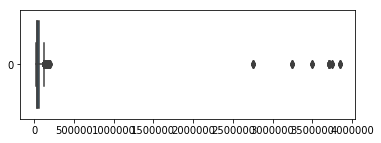

In [29]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.boxplot(data=working_jobs.Avg_Salary, orient='h')
plt.show()

In [30]:
# There are some points that seem to have incorrect data that I will drop:

working_jobs = working_jobs[working_jobs.Avg_Salary < 250000]
working_jobs.reset_index(drop=True,inplace=True)

In [31]:
working_jobs.shape

(1667, 9)



**Cleaning kind of job information**

In [32]:
# Dictionary of keywords to determine seniority level:

seniority_dict = {"junior_level": ["internship","intern","assistant","junior",
                                   "aprenticeship","apprenticeship","entry"],
                  "senior_level": ["manager","director","vp", "chief",
                                   "senior","lead","leader","principal","expert","head",
                                  "years","phd","expertise","experienced","phd","mentor"]}

In [33]:
# Getting a list of cleaned positions

kind_list = []
for each in working_jobs.index:
    final_word = ""
    append = False
    try:
        words = working_jobs.Kind.iloc[each].split()
        for word in words[2:]:
            if word != "salaries":
                final_word = final_word + word
            elif word == "salaries":
                for level in seniority_dict:
                    for seniority in seniority_dict[level]:
                        if seniority in final_word.lower():
                            final_word = final_word.lower().replace(seniority,"")
                        if "scientist" in final_word.lower():
                            final_word = "datascientist"
                kind_list.append(final_word.lower())
                append = True
                break
    except:
        None
    if not append:
        kind_list.append(np.nan)

In [34]:
working_jobs["Job_Kind"] = kind_list

In [35]:
working_jobs.Job_Kind.value_counts().head()

datascientist                    541
researchassociate                 62
developmentoperationsengineer     55
researchfellow                    50
machinelearningengineer           22
Name: Job_Kind, dtype: int64

**Creating job levels column**

In [36]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [37]:
# Getting a list with seniority levels
# NOTE: the following code asumes than any job posting not containing any of the words on
# the seniority_dict is a middle_level job

seniority_levels = []
for each in working_jobs.index:
    
    append = False
    job_words = working_jobs.Job.iloc[each].split()
    
    for word_in_title in job_words:
        for key in seniority_dict.keys():
            for level in seniority_dict[key]:
                # Excluding this words from stemmer because of ambiguety when using it
                if level == "internship" or level == "entry" or level == "intern":
                    w_check = level.lower()
                else:
                    w_check = stemmer.stem(level.lower())
                if stemmer.stem(word_in_title.lower()) == w_check:
                    if append == False:
                        seniority_levels.append(key)
                        append = True
                    
    if append == False:
        summary_words = working_jobs.Summary.iloc[each].split()
        
        for word_in_summary in summary_words:
            for key in seniority_dict.keys():
                for level in seniority_dict[key]:
                    # Excluding this words from stemmer because of ambiguety when using it
                    if level == "internship" or level == "entry" or level == "intern": 
                        w_check = level.lower()
                    else:
                        w_check = stemmer.stem(level.lower())                   
                    if stemmer.stem(word_in_summary.lower()) == w_check:
                        if not append:
                            seniority_levels.append(key)
                            append = True
                        
    if append == False:
        seniority_levels.append("middle_level")

In [38]:
seniority_df = pd.DataFrame(seniority_levels,columns=["Seniority"])

In [39]:
seniority_df.Seniority.value_counts()

middle_level    878
senior_level    475
junior_level    314
Name: Seniority, dtype: int64

In [40]:
seniority_df.shape

(1667, 1)

In [41]:
working_jobs.shape

(1667, 10)

In [42]:
working_jobs["Seniority"] = seniority_levels

In [43]:
working_jobs.Seniority.value_counts()

middle_level    878
senior_level    475
junior_level    314
Name: Seniority, dtype: int64

**Cleaning location information**

In [44]:
working_jobs.Location.value_counts().head(10)

London            359
United Kingdom    192
Berkshire          76
Manchester         75
Leeds              59
Derbyshire         54
East Kilbride      53
Warrington         38
Glasgow            37
Buxton             33
Name: Location, dtype: int64

In [45]:
# As the Location scrapped from Indeed in the UK has cities, boroughs, and even a mix of both o simply UK
# I will be dropping that column, and keeping the one created from the filters

In [46]:
final_working_jobs = working_jobs.copy()

In [47]:
final_working_jobs.drop("Location",axis=1,inplace=True)

**Final checks: coherence, null values, duplicates and last drops**

In [48]:
final_working_jobs.isnull().sum()

Company         0
Job             0
Summary         0
Kind          320
City            0
Job_Type        0
Industry        0
Avg_Salary      0
Job_Kind      413
Seniority       0
dtype: int64

In [49]:
# Dropping the scrapped "Kind" columns since now we have the cleaned one

final_working_jobs.drop('Kind',axis=1,inplace=True)

In [50]:
# Null values in "Job_Kind" correspond to not identified job kinds:

final_working_jobs.Job_Kind = final_working_jobs.Job_Kind.fillna("Unknown")

In [51]:
final_working_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 9 columns):
Company       1667 non-null object
Job           1667 non-null object
Summary       1667 non-null object
City          1667 non-null object
Job_Type      1667 non-null object
Industry      1667 non-null object
Avg_Salary    1667 non-null float64
Job_Kind      1667 non-null object
Seniority     1667 non-null object
dtypes: float64(1), object(8)
memory usage: 117.3+ KB


In [52]:
# Storing "Job" column apart just in case I need it later

job_df = final_working_jobs.pop("Job")
job_df = pd.DataFrame(job_df,columns=["Jobs"])

In [53]:
# Storing "Summary" to vectorize it:

summary_df = final_working_jobs.pop("Summary")
summary_df = pd.DataFrame(summary_df,columns=["Summary"])

In [54]:
final_working_jobs.head()

,Company,City,Job_Type,Industry,Avg_Salary,Job_Kind,Seniority
0,Nesta,London,contract,Organization,30000.0,datascientist,junior_level
1,Pivigo Ltd,London,contract,Other,130000.0,datascientist,middle_level
2,CMW International,London,contract,Other,117000.0,datascientist,middle_level
3,J&C Associates Ltd,London,contract,Other,21190.0,datascientist,middle_level
4,Salt Recruitment,London,contract,Consulting and Business Services,143000.0,datascientist,senior_level


In [55]:
final_working_jobs.shape

(1667, 7)

In [56]:
# Final check for duplicates
final_working_jobs.drop_duplicates(keep="last", inplace=True)

In [57]:
final_working_jobs.shape

(1207, 7)

**Checking companies with repetaed job postings**

In [58]:
# Checking companies with an unusual number of lot of job postings:
final_working_jobs.Company.value_counts().head()

Center for Combating Extremist Ideology     103
Hobson Prior                                 53
STFC                                         53
UK Government - Department for Education     46
Harnham                                      36
Name: Company, dtype: int64

In [59]:
# Checking the max and min number of repeated job postings in each one of the top 20 companies seen above

weird_companies = list(final_working_jobs.Company.value_counts().iloc[0:20].index)
weird_companies_to_remove = []
for each in weird_companies:
    print("Company:" + each)
    max_postings = final_working_jobs[final_working_jobs.Company==each].City.value_counts().max()
    min_postings = final_working_jobs[final_working_jobs.Company==each].City.value_counts().min()
    print("Max Jobs posting reps:" + str(max_postings))
    print("Min Jobs posting reps:" + str(min_postings))
    print("")
    
    if max_postings >= 10 or min_postings >= 5:
          weird_companies_to_remove.append(each)

Company:Center for Combating Extremist Ideology
Max Jobs posting reps:3
Min Jobs posting reps:1

Company:Hobson Prior
Max Jobs posting reps:10
Min Jobs posting reps:8

Company:STFC
Max Jobs posting reps:8
Min Jobs posting reps:1

Company:UK Government - Department for Education
Max Jobs posting reps:10
Min Jobs posting reps:5

Company:Harnham
Max Jobs posting reps:11
Min Jobs posting reps:1

Company:University of Derby
Max Jobs posting reps:9
Min Jobs posting reps:5

Company:Head Resourcing Limited
Max Jobs posting reps:7
Min Jobs posting reps:1

Company:UK Government - Office for National Statistics
Max Jobs posting reps:15
Min Jobs posting reps:12

Company:CK Group
Max Jobs posting reps:6
Min Jobs posting reps:1

Company:UK Government - Health and Safety Executive
Max Jobs posting reps:5
Min Jobs posting reps:1

Company:Transport for London
Max Jobs posting reps:4
Min Jobs posting reps:2

Company:UK Government - Defence Science and Technology Lab...
Max Jobs posting reps:9
Min Jobs p

In [60]:
# The following list was created from the above function, composed of companies to be dropped
# since they have suspicious numbers of repetead job posts:

weird_companies_to_remove

['Hobson Prior',
 'UK Government - Department for Education',
 'Harnham',
 'University of Derby',
 'UK Government - Office for National Statistics',
 'University of Glasgow']

In [61]:
# Dropping companies with a suspicious number of repeated job postings

final_working_jobs = final_working_jobs[~final_working_jobs.Company.isin(weird_companies_to_remove)]
final_working_jobs.reset_index(drop=True,inplace=True)

In [62]:
# Final check on companies

final_working_jobs.Company.value_counts().head()

Center for Combating Extremist Ideology        103
STFC                                            53
Head Resourcing Limited                         29
CK Group                                        23
UK Government - Health and Safety Executive     20
Name: Company, dtype: int64

In [63]:
# Check on the ones with more job posts

final_working_jobs[final_working_jobs.Company=="Center for Combating Extremist Ideology"].head()

,Company,City,Job_Type,Industry,Avg_Salary,Job_Kind,Seniority
70,Center for Combating Extremist Ideology,London,contract,Other,55000.0,Unknown,junior_level
119,Center for Combating Extremist Ideology,Birmingham,contract,Other,55000.0,Unknown,middle_level
120,Center for Combating Extremist Ideology,Birmingham,contract,Other,55000.0,Unknown,junior_level
127,Center for Combating Extremist Ideology,Birmingham,fulltime,Other,55000.0,Unknown,junior_level
136,Center for Combating Extremist Ideology,Liverpool,contract,Other,55000.0,Unknown,middle_level


In [64]:
# STFC doesn't seem to have anything rare, since it has multiple job kinds and average salary for its publications:

final_working_jobs[final_working_jobs.Company=="STFC"].head()

,Company,City,Job_Type,Industry,Avg_Salary,Job_Kind,Seniority
145,STFC,Liverpool,fulltime,Other,40447.0,datascientist,middle_level
147,STFC,Liverpool,fulltime,Other,37679.0,datascientist,middle_level
149,STFC,Liverpool,fulltime,Other,36679.0,datascientist,middle_level
151,STFC,Liverpool,fulltime,Other,32120.5,softwareengineer,middle_level
152,STFC,Liverpool,fulltime,Other,36679.0,Unknown,middle_level


In [65]:
# Removing "Center for Combating Extremist Ideology" because of suspicious post jobs

final_working_jobs = final_working_jobs[final_working_jobs.Company!="Center for Combating Extremist Ideology"]
final_working_jobs.reset_index(drop=True,inplace=True)

In [66]:
final_working_jobs.shape

(898, 7)

In [67]:
# Creating a list with the index of the rows removed, to dropped them from the summary_df

removed_index = []
for x in summary_df.index:
    if x not in final_working_jobs.index:
        removed_index.append(x)

**Vectorizing summary**

In [68]:
# Removing rows droped from previous DataFrame

summary_df = summary_df[~summary_df.index.isin(removed_index)]
summary_df.reset_index(drop=True,inplace=True)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words='english')
tvec.fit(summary_df.Summary)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [70]:
tvec_mat = pd.DataFrame(np.round(tvec.fit_transform(summary_df.Summary).toarray(),3),columns=tvec.get_feature_names())

In [71]:
word_importance = []
for each in tvec_mat.columns:
    word_importance.append(tvec_mat[each].sum())
    
pd.DataFrame(word_importance,columns=["Sum"],index=tvec_mat.columns).sort_values("Sum",ascending=False).head(10)

,Sum
data,114.486
scientist,43.474
science,41.059
using,34.912
research,34.315
development,33.777
leading,32.141
assist,32.103
activities,31.382
conducting,31.247


In [72]:
tvec_mat.shape

(898, 1400)

### Save your results as a CSV

In [73]:
final_working_jobs.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/final_working_jobs.csv',
                 index=False)

In [74]:
tvec_mat.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/tvec_mat.csv',
                 index=False)

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

#### Load in the the data of scraped salaries

In [2]:
base_df = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/final_working_jobs.csv')

In [3]:
base_df.head()

,Company,City,Job_Type,Industry,Avg_Salary,Job_Kind,Seniority
0,Nesta,London,contract,Organization,30000.0,datascientist,junior_level
1,Pivigo Ltd,London,contract,Other,130000.0,datascientist,middle_level
2,CMW International,London,contract,Other,117000.0,datascientist,middle_level
3,J&C Associates Ltd,London,contract,Other,21190.0,datascientist,middle_level
4,Salt Recruitment,London,contract,Consulting and Business Services,143000.0,datascientist,senior_level


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [4]:
base_df["Salary_Q"] = ["A" if salary < int(base_df.Avg_Salary.quantile(0.25)) else 
                  "B" if salary < int(base_df.Avg_Salary.quantile(0.50)) else 
                  "C" if salary < int(base_df.Avg_Salary.quantile(0.75)) else "D"
                  for salary in base_df.Avg_Salary]

#### Thought experiment: What is the baseline accuracy for this model?

In [5]:
base_df.Salary_Q.value_counts()

B    243
D    229
C    221
A    205
Name: Salary_Q, dtype: int64

In [6]:
# The baseline accuracy for this model is the probability of predicting
# Category B, which is the predominant category:

base_df[base_df.Salary_Q=="B"].Salary_Q.value_counts()/base_df.Salary_Q.value_counts().sum()

B    0.270601
Name: Salary_Q, dtype: float64

In [7]:
y = base_df.pop("Salary_Q")

### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. [DONE]
- Use logistic regression with both statsmodels and sklearn. [DONE]
- Use a further classifier you find suitable. [DONE]
- Remember that scaling your features might be necessary. [DONE]
- Display the coefficients/feature importances and write a short summary of what they mean. [DONE]

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title. [DONE]
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. [DONE]
- Incorporate other text features from the title or summary that you believe will predict the salary. [DONE]
- Then build new classification models including also those features. Do they add any value? [DONE]
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. [DONE] 
- Discuss model coefficients or feature importances as applicable. [DONE]

#### Model evaluation: 
**[THIS IS GOING TO BE ANSWERED LATER WITH THE BONUS QUESTION]**

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from scipy import sparse

### Fitting a BINARY model only based on location, in order to compare sklearn and statsmodel

**Setting up variables**

In [9]:
base_df["Salary_Q"] = [0 if salary < int(base_df.Avg_Salary.quantile(0.50)) else 1
                  for salary in base_df.Avg_Salary]

In [10]:
yl = base_df.pop("Salary_Q")

In [11]:
cities_dum_df = pd.get_dummies(base_df.City,drop_first=True)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    cities_dum_df, yl.astype(str), test_size=0.3, stratify=y, random_state=123)

**Statsmodel version**

In [13]:
import statsmodels.formula.api as sm

In [14]:
X_i = X_train.copy()

stats_model = sm.Logit(y_train.astype(float), X_i.astype(float)).fit(method='lbfgs',maxiter=500)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [15]:
trainpred = stats_model.predict(X_train)
trainpred = (trainpred > .5)*1

In [16]:
testpred = stats_model.predict(X_test)
testpred = (testpred > .5)*1

In [17]:
print(accuracy_score(y_test.astype(int),testpred))

0.6003184713375797


**Sklearn version**

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [19]:
model = LogisticRegressionCV(max_iter = 500)

In [20]:
params = {'penalty': ['l2'],
          'solver': ['lbfgs'],
          'Cs': [np.logspace(-2.5, 2.5, 10)],
          'multi_class': ['ovr'],
}

In [21]:
city_gd = GridSearchCV(model, params, cv=5, n_jobs=-1)

In [22]:
city_gd.fit(X_train,y_train)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=500,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l2'], 'solver': ['lbfgs'], 'Cs': [array([3.16228e-03, 1.13646e-02, 4.08424e-02, 1.46780e-01, 5.27500e-01,
       1.89574e+00, 6.81292e+00, 2.44844e+01, 8.79923e+01, 3.16228e+02])], 'multi_class': ['ovr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
city_gd.score(X_test,y_test)

0.6146496815286624

**Using another classifier**

In [382]:
X_train.shape

(270, 48)

In [384]:
binary_model_2 = DecisionTreeClassifier(max_depth = 100, max_features = 0.8)

In [386]:
boosting_binary = AdaBoostClassifier(base_estimator = binary_model_2, n_estimators = 500, random_state=123)

In [387]:
boosting_binary.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
            max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=123)

In [389]:
boosting_binary.score(X_test,y_test)

0.6003184713375797

**Feature importance**

In [24]:
# create a dataframe to look at the coefficients
coef_df = pd.DataFrame({'feature': X_train.columns,
                        'coef': city_gd.best_estimator_.coef_[0],
                        'abs_coef': np.abs(city_gd.best_estimator_.coef_[0])})

coef_df.head()

,feature,coef,abs_coef
0,Bangor,0.021362,0.021362
1,Basingstoke,-0.016902,0.016902
2,Belfast,-0.038985,0.038985
3,Birmingham,0.041284,0.041284
4,Blackburn,-0.038985,0.038985


In [25]:
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df.reset_index(drop=True,inplace=True)
coef_df.head()

,feature,coef,abs_coef
0,London,0.351387,0.351387
1,Croydon,0.106866,0.106866
2,Southampton,-0.091840,0.091840
3,Wakefield,0.080524,0.080524
4,York,0.060991,0.060991


In [26]:
coef_df["ranking"] = [x for x in range(coef_df.shape[0])]

In [27]:
# searching for the biggest cities
top_5_cities = ["London","Birmingham","Liverpool","Nottingham","Sheffield"]
coef_df[coef_df["feature"].isin(top_5_cities)]

,feature,coef,abs_coef,ranking
0,London,0.351387,0.351387,0
14,Birmingham,0.041284,0.041284,14
28,Nottingham,0.020741,0.020741,28
33,Sheffield,-0.019689,0.019689,33
43,Liverpool,0.003933,0.003933,43


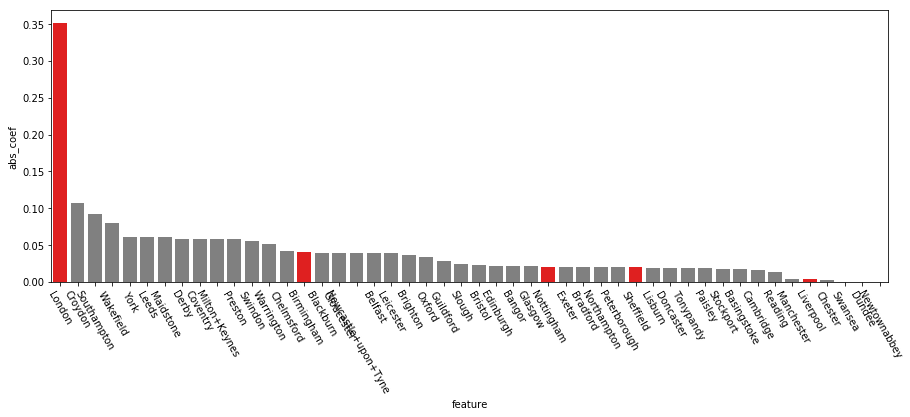

In [28]:
custom_palette = []
for feature in coef_df.feature:
    if feature in top_5_cities:
        custom_palette.append('red')
    else:
        custom_palette.append('grey')

plt.figure(figsize=(15,5));
sns.barplot(x=coef_df.feature.head(50), y=coef_df.abs_coef.head(50), palette=custom_palette);
plt.xticks(rotation=-60);

**Conclusions:**

* For this binary classification, both models performed very similar, obtaining an accuracy score around 0.60 on the train test


* In terms of feature importance, we can see how logically, London is the city that influences more the predictions by far. However, an interesting finding is that the rest of the top 5 cities of the UK -in terms of pupulation-, althought all of them appear within the 50 more influent cities, neither of them are that relevant, in comparisson with others tat have much less population.

### Running multinomial models with different features

**Prepparing a set of DataFrames**

**1. DataFrame with Summary Vector**

In [29]:
summary_df = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/tvec_mat.csv')

In [30]:
summary_df.head()

,000,0191,10,115,12,15,20,2019,30,30000,...,work,worked,working,works,world,wrangle,write,writing,written,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.267,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0


In [31]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Columns: 1400 entries, 000 to years
dtypes: float64(1400)
memory usage: 9.6 MB


In [32]:
summary_sparse = sparse.csr_matrix(summary_df)

**2. Base DataFrame with original columns**

In [33]:
base_df_dumm = base_df.copy()

In [34]:
# Dropping salary from our final dataset, since we are going to predict salary categories

base_df_dumm.drop("Avg_Salary",axis=1,inplace=True)

In [35]:
base_df_dumm.head()

,Company,City,Job_Type,Industry,Job_Kind,Seniority
0,Nesta,London,contract,Organization,datascientist,junior_level
1,Pivigo Ltd,London,contract,Other,datascientist,middle_level
2,CMW International,London,contract,Other,datascientist,middle_level
3,J&C Associates Ltd,London,contract,Other,datascientist,middle_level
4,Salt Recruitment,London,contract,Consulting and Business Services,datascientist,senior_level


In [36]:
# Selecting myself the columns to be dropped after dummification:

some_columns = ["Company","City","Job_Type"]
droppers = [each + "_" + base_df_dumm.sort_values(each)[each].head(1).values[0] for each in some_columns]
droppers.append("Industry_Other")
droppers.append("Job_Kind_Unknown")

In [37]:
base_df_dumm = pd.get_dummies(base_df_dumm)

In [38]:
base_df_dumm.drop(droppers,axis=1,inplace=True)

In [39]:
base_df_dumm.shape

(898, 352)

In [40]:
base_df_dumm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Columns: 352 entries, Company_AMSI Consultancy Services to Seniority_senior_level
dtypes: uint8(352)
memory usage: 308.8 KB


In [41]:
base_df_dumm = base_df_dumm.apply(lambda x: x.astype(float))

In [42]:
base_df_dumm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Columns: 352 entries, Company_AMSI Consultancy Services to Seniority_senior_level
dtypes: float64(352)
memory usage: 2.4 MB


In [43]:
base_sparse = sparse.csr_matrix(base_df_dumm)

**3. DataFrame with the combination of summary vectorized + other features**

In [44]:
concat_df = pd.concat((base_df_dumm,summary_df),axis=1)

In [45]:
concat_df.drop(["index"],axis=1,inplace=True)

In [46]:
concat_df.head()

,Company_AMSI Consultancy Services,Company_AWE,Company_Accenture,Company_Acorn Recruitment Limited,Company_Ad Warrior,Company_Aiimi Ltd,Company_Anglian Water Services Ltd,Company_AquAffirm Ltd,Company_Aspire Recruitment Partnership,Company_Astex Pharmaceuticals,...,work,worked,working,works,world,wrangle,write,writing,written,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.267,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0


In [47]:
concat_sparse = sparse.csr_matrix(concat_df)

**Function to run models**

In [48]:
def modelarte(X_train, y_train, mr_model, model_params, optimizer = False, cv=5, score=accuracy_score):
    
    if not optimizer:
    
        #1: Creating grid search
        insta_base_estimator_gs = GridSearchCV(mr_model, param_grid=model_params, 
                                               cv=cv, n_jobs=2, refit=True, iid=False)

        #2: Fitting grid search
        insta_base_estimator_gs.fit(X_train,y_train)
        final_model = insta_base_estimator_gs
    
    if optimizer:

        #1: Creating grid search
        optimizer_gs = GridSearchCV(mr_model, param_grid=model_params, 
                                    cv=cv, n_jobs=2, refit=True, iid=False)

        #2: Fitting grid search
        optimizer_gs.fit(X_train,y_train)
        final_model = optimizer_gs
    
    return(final_model)

**MODELING | 1. First models only with dummy variables**

In [177]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(
base_df_dumm, y, test_size=0.2, stratify=y, random_state=123, shuffle = True)

scaler.fit(X_train_v1)
X_train_v1 = scaler.transform(X_train_v1)
X_test_v1 = scaler.transform(X_test_v1)
X_train_v1 = sparse.csr_matrix(X_train_v1)

Logistic Regression model

First model is only using LogisticRegression, wighout bagging or boosting, since as it is a stable classifier, LogisticRegression does not works well with ensemble methods, as it tends to not change much its performance when the training set is modified.

Also I won't be using grid search for this first model, as it takes too much to run in my computer and also because I did try a lot of combinations in previous runs from which I draw conclusions in terms of which parameter was important and which not, ending in the following combination:

In [180]:
log_model_v1 = LogisticRegressionCV(Cs = 20, penalty = "l2", solver = 'saga',
                                    max_iter = 5000, random_state = 123, cv = 5)

In [181]:
first_model_logreg = log_model_v1.fit(X_train_v1,y_train_v1)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [183]:
first_model_logreg.score(X_test_v1,y_test_v1)

0.8611111111111112

In [220]:
first_model_logreg.C_

array([0.01274275, 0.01274275, 0.01274275, 0.01274275])

In [104]:
np.logspace(0, 2.5, 5)

array([  1.        ,   4.21696503,  17.7827941 ,  74.98942093,
       316.22776602])

This managed to become my best models, using the base_df. 

In this case I tunned the following parameters:

* **solver**: I tried with 'liblinear', 'saga' and 'lbfgs'.


* **penalty**: This parameter represents the kind of regularization applied to the model. A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression. The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features. That's why I thought Lasso would work better in this case, since the dataset has 352 columns. However, Ridge enden up being the best kind of regularization. Typically Ridge is better for minimizing prediction error rather than Lasso because when two predictors are highly correlated, L1 regularizer will simply pick one of the two predictors. In contrast, the L2 regularizer will keep both of them and jointly shrink the corresponding coefficients a little bit.


* **Cs**: The Cs parameter stands for the inverse of regularization strength. In this case, I ended up using a strong penalty, since the final Cs value was very near to 0. That means that the regularization shrinked a lot the coefficients, what sounds reasonable, since I was working with a dataset with a lot of columns, so there was a lot of data the that wasn't very important.


Finally, it was necessary to increase a lot the number of iterations, in order to complete the process entirely.

KNeighbors Model with Bagging

In [186]:
# I ran this model tons of times and I went selecting the parameters, to reduce their amount in each iteration

knn_params_v1 = {'base_estimator__n_neighbors': [20,25,30],
                'base_estimator__p': [1],
                'base_estimator__weights': ['distance'],
                'max_samples': [1.0],
                'max_features': [0.7,0.8,0.9],
                'n_estimators': [500]}

In [754]:
knn_model_v1 = KNeighborsClassifier(n_jobs=2)

In [755]:
bagging_knn_model_v1 = BaggingClassifier(knn_model_v1)

In [756]:
first_model_knn = modelarte(X_train_v1, y_train_v1, bagging_knn_model_v1, knn_params_v1, optimizer=True)

In [763]:
first_model_knn.best_params_

{'base_estimator__n_neighbors': 25,
 'base_estimator__p': 1,
 'base_estimator__weights': 'distance',
 'max_features': 0.8,
 'max_samples': 1.0,
 'n_estimators': 500}

In [764]:
first_model_knn.score(X_test_v1,y_test_v1)

0.8513011152416357

In this case, I run a KNN model with bagging, in order to improve the results of the base estimator by averaging multiple runs of it, with several parameters. Although this model obtained a very good score, I was not able to experiment a lot with it because of it's extreme low velocity to run. 

However, I could optimize the following parameters, in order to get a better score:

* **n_neighbors**: in short, as we know, k-nearest neighbors works by checking the class of the nearest points to the one being predicted, in order to classify it. This parameter allows us to optimize the number of neighbors that are going to be chosen.


* **p**: when p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.


* **weights**: stands for the weight function used in prediction. I tried with 'uniform'  and 'distance'. The first one means that all points in each neighborhood are weighted equally. Meanwhile the second one weights the points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. This last option ended up being the better one for my dataset. What makes sense taking into account that for one salary category, there are points from several cities, industries, etc.


* **max_features**: this is a bagging parameter. Is the number of features to draw from X to train each base estimator. This feature was worth exploring for many different values, and it hade a large impact on the behavior of the model because, as it decides how many features are considered at each split. 


* **max_samples**: is the number of samples to draw from X to train each time. 1 means means that I took samples equally large to omy original dataset.


* **n_estimators**: the number of models that are going to be created by the Baggin Classifier. Usually, more models means a more robust average in the end, which results in a more reliable and solid score.

Decision Tree with Ada Boost

In [212]:
trees_params_v1 = {'base_estimator__max_depth': [80,100,120,150],
                   'base_estimator__max_features': [0.93,0.95,0.97],
                   'n_estimators': [1200]}

In [213]:
trees_model_v1 = DecisionTreeClassifier()

In [214]:
boosting_trees_model_v1 = AdaBoostClassifier(base_estimator = trees_model_v1, random_state=123)

In [215]:
first_model_trees = modelarte(X_train_v1, y_train_v1, boosting_trees_model_v1, trees_params_v1, optimizer=True)

In [216]:
first_model_trees.best_params_

{'base_estimator__max_depth': 80,
 'base_estimator__max_features': 0.95,
 'n_estimators': 1200}

In [217]:
first_model_trees.score(X_test_v1,y_test_v1)

0.8444444444444444

In [672]:
prediction_trees_v1 = first_model_trees.predict(X_test_v1)



In this model, I'm using Decision Trees with Ada Boost, in order to reduce bias and try to reduce variance as well.

Taking this into account, I touch the following parameters several times, until I got this score:

* **n_estimators**: already explain in the previous model


* **max_features** this is an interesting attribute while using boosting, since on of the issues with regression trees is the number of significant variables and the number of nonsignificant variables in the data set. It is known that when we have few interesting input variables and a large number of noise variables, the regression forests does not behave well. Boosting procedures does not have this behavior, since at each iteration only the region of interests have large weight, so the already learned regions are affected less.


* **max_samples**: this was also an interesting point since with decision trees exists the possibility of learning too well the data and if the data is not representative, then the results are bad. In which way the data might not be representative? For example could happen that I had not enought data for one kind of seniority.

Classification Report and ROC for this dataset

In [377]:
first_pred = first_model_logreg.predict(X_test_v1)

In [378]:
print(metrics.classification_report(y_test_v1, first_pred))

              precision    recall  f1-score   support

           A       0.90      0.88      0.89        41
           B       0.88      0.86      0.87        49
           C       0.80      0.75      0.78        44
           D       0.86      0.96      0.91        46

   micro avg       0.86      0.86      0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



In [380]:
first_y_test_bin = label_binarize(y_test_v1, first_model_logreg.classes_)

In [381]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(first_model_logreg.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(
        first_y_test_bin[:, i], first_model_logreg.predict_proba(X_test_v1)[:, i]), 2))

Area under ROC curve (ROC-AUC):
Class A: 0.99
Class B: 0.96
Class C: 0.94
Class D: 0.99


**MODELING | 2. Second model only with vectorized summary**

In [ ]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
summary_df, y, test_size=0.2, stratify=y, random_state=123, shuffle = True)

scaler.fit(X_train_v2)
X_train_v2 = scaler.transform(X_train_v2)
X_test_v2 = scaler.transform(X_test_v2)
X_train_v2 = sparse.csr_matrix(X_train_v2)

Logistic Regression model

Starting just with Linear Regression without Grid Search because of the same reasons explained for the first model.

In [141]:
log_model_v2 = LogisticRegressionCV(max_iter = 10000, random_state = 123, cv = 5,
                                   penalty = "l2", solver = "saga", Cs = 100, multi_class = 'multinomial')

In [142]:
log_model_v2.fit(X_train_v2,y_train_v2)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=10000,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=123, refit=True, scoring=None, solver='saga',
           tol=0.0001, verbose=0)

In [145]:
log_model_v2.score(X_test_v2,y_test_v2)

0.25069637883008355

Classification Report and ROC for this dataset

In [372]:
second_pred = log_model_v2.predict(X_test_v2)

In [373]:
print(metrics.classification_report(y_test_v2, second_pred))

              precision    recall  f1-score   support

           A       0.21      0.26      0.23       164
           B       0.26      0.30      0.28       194
           C       0.28      0.24      0.26       177
           D       0.26      0.19      0.22       183

   micro avg       0.25      0.25      0.25       718
   macro avg       0.25      0.25      0.25       718
weighted avg       0.25      0.25      0.25       718



In [375]:
second_y_test_bin = label_binarize(y_test_v2, log_model_v2.classes_)

In [376]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(log_model_v2.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(
        second_y_test_bin[:, i], log_model_v2.predict_proba(X_test_v2)[:, i]), 2))

Area under ROC curve (ROC-AUC):
Class A: 0.47
Class B: 0.48
Class C: 0.52
Class D: 0.52


**This model is very very far away from any metric obtained with the base information, so I'm not going to explore any more models with this dataset**

**MODELING | 3. Third model using vectorized summary + base df**

In [153]:
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(
concat_df, y, test_size=0.2, stratify=y, random_state=123, shuffle = True)

scaler.fit(X_train_v3)
X_train_v3 = scaler.transform(X_train_v3)
X_test_v3 = scaler.transform(X_test_v3)
X_train_v3 = sparse.csr_matrix(X_train_v3)

Decision Tree with Boost

In [164]:
trees_params_v3 = {'base_estimator__max_depth': [1,2,3,4,5],
                   'base_estimator__max_features': [0.75,0.85,0.05],
                   'n_estimators': [100]}

In [165]:
trees_model_v3 = DecisionTreeClassifier()

In [166]:
boosting_trees_model_v3 = AdaBoostClassifier(base_estimator = trees_model_v3, random_state=123)

In [167]:
first_model_trees_v3 = modelarte(X_train_v3, y_train_v3, boosting_trees_model_v3, trees_params_v3, optimizer=True)

In [168]:
first_model_trees_v3.best_params_

{'base_estimator__max_depth': 5,
 'base_estimator__max_features': 0.75,
 'n_estimators': 100}

In [301]:
first_model_trees_v3.score(X_test_v3,y_test_v3)

0.4178272980501393

Classification Report and ROC for this dataset

In [365]:
third_pred = first_model_trees_v3.predict(X_test_v3)

In [366]:
print(metrics.classification_report(y_test_v3, third_pred))

              precision    recall  f1-score   support

           A       0.36      0.45      0.40       164
           B       0.36      0.36      0.36       194
           C       0.37      0.33      0.35       177
           D       0.60      0.54      0.57       183

   micro avg       0.42      0.42      0.42       718
   macro avg       0.42      0.42      0.42       718
weighted avg       0.42      0.42      0.42       718



In [368]:
third_y_test_bin = label_binarize(y_test_v3, first_model_trees_v3.classes_)

In [370]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(first_model_trees_v3.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(
        third_y_test_bin[:, i], first_model_trees_v3.predict_proba(X_test_v3)[:, i]), 2))

Area under ROC curve (ROC-AUC):
Class A: 0.65
Class B: 0.62
Class C: 0.62
Class D: 0.8


**This model is taking almost the minimum max_depth and an intermediate max_features parameter, and it's very far from the score I got only with the base data. Also, it has worst recall, precision and area under the ROC curve, so I'm not going to go deeper with this option**

**Feature importance**

Feature importance is going to be done using the base_df predictions with Logistic Regression CV, as it was the model which obtained the best score.

Saving everything before advancing just in case

In [237]:
final_pred_train = first_model_logreg.predict(X_train_v1)
final_pred_test = first_model_logreg.predict(X_test_v1)
final_prob_train = first_model_logreg.predict_proba(X_train_v1)
final_prob_test = first_model_logreg.predict_proba(X_test_v1)

In [240]:
final_pred_train_df = pd.DataFrame(final_pred_train,columns=["pred"])
final_pred_test_df = pd.DataFrame(final_pred_test,columns=["pred"])
final_prob_train_df = pd.DataFrame(final_prob_train,columns=["A","B","C","D"])
final_prob_test_df = pd.DataFrame(final_prob_test,columns=["A","B","C","D"])

In [225]:
final_pred_train_df.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/final_pred_train.csv',
                 index=False)

In [226]:
final_pred_test_df.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/final_pred_test.csv',
                 index=False)

In [241]:
final_prob_train_df.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/final_prob_train.csv',
                 index=False)

In [242]:
final_prob_test_df.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-4/final_prob_test.csv',
                 index=False)

Checking for Feature Importance

In [247]:
# create a dataframe to look at the coefficients
final_pred_coef_df = pd.DataFrame({'feature': base_df_dumm.columns,
                                   'coefA': np.abs(first_model_logreg.coef_[0]),
                                   'coefB': np.abs(first_model_logreg.coef_[1]),
                                   'coefC': np.abs(first_model_logreg.coef_[2]),
                                   'coefD': np.abs(first_model_logreg.coef_[3]),})

final_pred_coef_df.head()

,feature,coefA,coefB,coefC,coefD
0,Company_AMSI Consultancy Services,0.029196,0.049440,0.106503,0.027979
1,Company_AWE,0.094433,0.050060,0.029280,0.017410
2,Company_Accenture,0.017071,0.039565,0.090093,0.032233
3,Company_Acorn Recruitment Limited,0.057541,0.028030,0.135689,0.052996
4,Company_Ad Warrior,0.032546,0.061491,0.127542,0.032930


In [256]:
final_pred_coef_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
feature    352 non-null object
coefA      352 non-null float64
coefB      352 non-null float64
coefC      352 non-null float64
coefD      352 non-null float64
dtypes: float64(4), object(1)
memory usage: 13.8+ KB


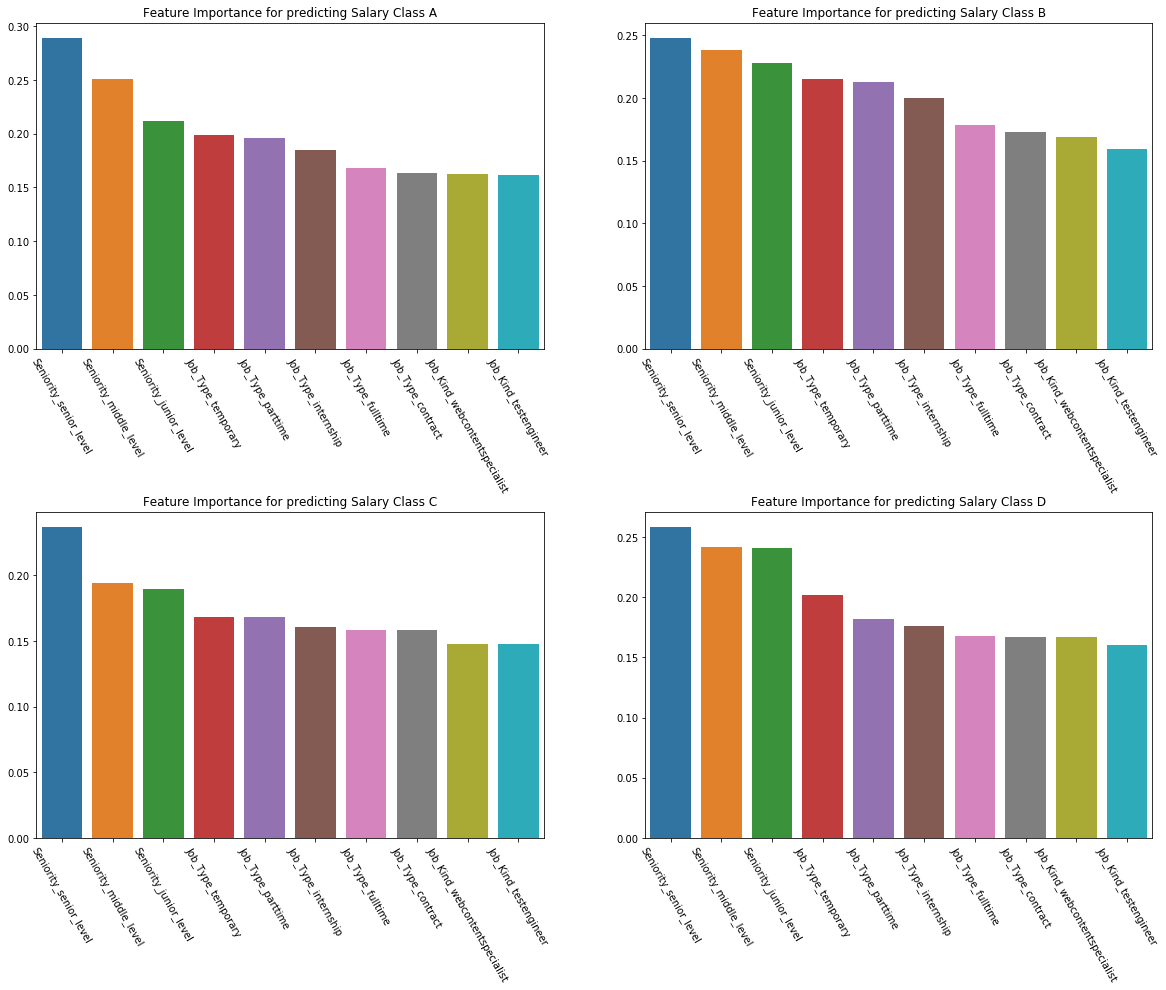

In [300]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 15));

plt.subplots_adjust(hspace = 0.5)

barplot11 = sns.barplot(x=final_pred_coef_df["feature"].sort_values(ascending=False).head(10).values,
            y=final_pred_coef_df["coefA"].sort_values(ascending=False).head(10).values, ax=ax1);

barplot12 = sns.barplot(x=final_pred_coef_df["feature"].sort_values(ascending=False).head(10).values,
            y=final_pred_coef_df["coefB"].sort_values(ascending=False).head(10).values, ax=ax2);

barplot21 = sns.barplot(x=final_pred_coef_df["feature"].sort_values(ascending=False).head(10).values,
            y=final_pred_coef_df["coefC"].sort_values(ascending=False).head(10).values, ax=ax3);

barplot22 = sns.barplot(x=final_pred_coef_df["feature"].sort_values(ascending=False).head(10).values,
            y=final_pred_coef_df["coefD"].sort_values(ascending=False).head(10).values, ax=ax4);

barplot11.set_xticklabels(barplot11.get_xticklabels(), rotation=-60);
barplot11.set_title("Feature Importance for predicting Salary Class A");
barplot12.set_xticklabels(barplot12.get_xticklabels(), rotation=-60);
barplot12.set_title("Feature Importance for predicting Salary Class B");
barplot21.set_xticklabels(barplot21.get_xticklabels(), rotation=-60);
barplot21.set_title("Feature Importance for predicting Salary Class C");
barplot22.set_xticklabels(barplot22.get_xticklabels(), rotation=-60);
barplot22.set_title("Feature Importance for predicting Salary Class D");

Before analyzing the previous charts, let's introduce a friendly reminder of what are we trying to predict:

* 4 different salary categories
* Salaries of what? Data science related job posts in Indeed.co.uy
* And from where those categories come from? From the average salary of Indeed's publications
* And how many categories are we trying to predict? Four divided into quartiles

Having said that, using the base_df, we can see there are some clear features that determine if one job posts is in one category or another:

* Seniority: this categoty was created from the original Job Title and Summary, classifying publications according to the presence or not of some words. As we can see, the tree levels impact very strongly in all categories, being the first coefficients in terms of absolute size

* In the second place, comes the Job_Type. This feature represents the kind of contract of each publication, and was obtained from the default filters Indeed has to search publications. Using it to navigate through the site, enabled me to also saved it as a feature to input into the model

* Finally, we've for all the salary categories, 2 kinds of jobs, that are the titles scrapped and cleaned from indeed: Web Content Specialist and Test Engineer 

This dataset contains hundreds of features, but it's nice to see there's a clear trend throughout the categories, at least regarding the most important features.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">



#### IMPORTANT NOTE: **In the following section I'm gonna answer the bonus question and the model evaluation task asked previously:**

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. [PREVIOUSLY DONE FOR ALL MODELS]
- Evaluate the accuracy, AUC, precision and recall of the models. [PREVIOUSLY DONE FOR ALL DATASETS]
- Plot the ROC and precision-recall curves for at least one of your models. [DONE]

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. [DONE]
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario. [DONE]
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare. [DONE]

In [356]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("gist_rainbow_r"))

In [357]:
print(metrics.classification_report(y_test_v1, final_pred_test_df))

              precision    recall  f1-score   support

           A       0.90      0.88      0.89        41
           B       0.88      0.86      0.87        49
           C       0.80      0.75      0.78        44
           D       0.86      0.96      0.91        46

   micro avg       0.86      0.86      0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



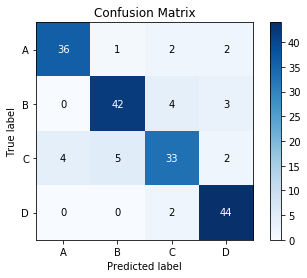

In [358]:
skplt.metrics.plot_confusion_matrix(y_test_v1, final_pred_test_df)
plt.show()

In [334]:
print(metrics.classification_report(y_train_v1, final_pred_train_df))

              precision    recall  f1-score   support

           A       0.93      0.96      0.95       164
           B       0.94      0.97      0.96       194
           C       0.97      0.91      0.94       177
           D       0.97      0.97      0.97       183

   micro avg       0.95      0.95      0.95       718
   macro avg       0.95      0.95      0.95       718
weighted avg       0.95      0.95      0.95       718



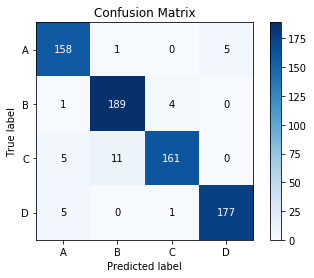

In [318]:
skplt.metrics.plot_confusion_matrix(y_train_v1, final_pred_train_df)
plt.show()

As we can see in the previous Confusion Matrix, the model based on Logistic Regression, predicted very well all the categories, with a slightly better performance for categories A and D.

Also, as shown in the classification report, the model presents very good values for Recall and Precision. However, the boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. So basically I need to take the Recall to 1 for classes A and B, that are the ones that indicate the lower half of salaries.

So, let's see the current ROC and precision-recall plots to proceed with the analysis:

In [335]:
y_test_bin = label_binarize(y_test_v1, first_model_logreg.classes_)

In [339]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(first_model_logreg.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(
        y_test_bin[:, i], first_model_logreg.predict_proba(X_test_v1)[:, i]), 2))

Area under ROC curve (ROC-AUC):
Class A: 0.99
Class B: 0.96
Class C: 0.94
Class D: 0.99


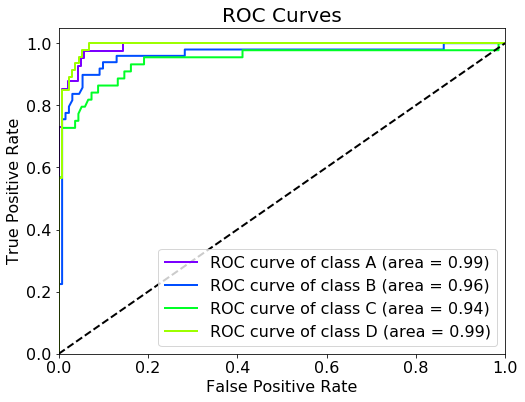

In [359]:
skplt.metrics.plot_roc(y_test_v1, first_model_logreg.predict_proba(X_test_v1), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()


So here we have some interesting findings here:

* For the first category of salaries, named "A", it seems that we can take our True Positive Rate -also known as Recall- to 1 without affecting so much our False Positive Rate. In english this means we can adjust our threshold to predict as "A" all of the "A" values, without getting too much False Positives


* However, for the second category of "low salaries", named "B", corresponding to those between the percentiles 0.25 and 0.50, modifying our threshold to predict all the positive values as positive, would imply predicting a lot of negative values incorrectely, as we would be ending with a False Positive Rate around 0.85. So I wouldn't recommend to follow the strategy my boss is raising. 

We can confirm this, by checking the Precision Recall Curve:

In [346]:
print('Area under precision-recall curve:')
for i, class_ in enumerate(first_model_logreg.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin[:, i], first_model_logreg.predict_proba(X_test_v1)[:, i]), 4))

Area under precision-recall curve:
Class A: 0.972
Class B: 0.925
Class C: 0.9083
Class D: 0.9753


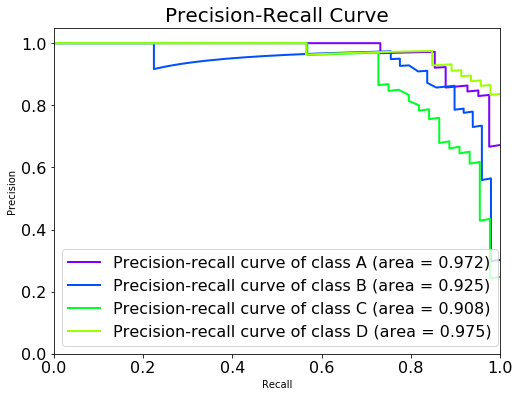

In [360]:
skplt.metrics.plot_precision_recall(y_test_v1, first_model_logreg.predict_proba(X_test_v1), plot_micro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()


So in the end, we have a very solid model to predict categories when the importance of them is equal, and we don’t have the need for pondering any class or classes. In that case, I should work on a new model with weighted categories.

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

https://docs.google.com/document/d/1s-BsA0gQ91M7TCeXxvTZf0fPDn4Iznvrr2bUrUPmp7Q/edit?usp=sharing

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

https://www.linkedin.com/pulse/from-job-posts-salary-categories-classification-ferreiro-volpi